# How to obtain pseudo-bulk counts and conduct some preliminary analyses 

This documentation contains instruction on how to obtain pseudo-bulk raw data from the single cell integrated map, with data from the Human Pancreas Analysis Program, Integrated Islet Distribution Program, and Prodo Labs.

In [2]:
suppressMessages(library(Seurat))
suppressMessages(library(stringr))
suppressMessages(library(parallel))
suppressMessages(library(readr))
suppressMessages(library(DESeq2))
suppressMessages(library(limma))
suppressMessages(library(edgeR))
suppressMessages(library(GenomicFeatures))
suppressMessages(library(data.table))
library(ggplot2)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(S4Vectors))
suppressPackageStartupMessages(library(GenomicRanges))
library(patchwork)
library(biomaRt)
library(harmony)
library(reticulate)

Loading required package: Rcpp



## Pseudobulk

In [ ]:
data <- readRDS("/nfs/turbo/umms-scjp-pank/4_integration/results/202503_freeze/202504_freeze/20250424_final__min.cells1_min.features1_rmIndivDblts_rmClustAbv65pct_harmonized_data.Rds")
print(data)

In [ ]:
data@meta.data$coarse_annot <- gsub(" ", "", data@meta.data$coarse_annot)
Idents(data) <- data@meta.data$coarse_annot
unique_cell_types <- unique(data$coarse_annot)

DefaultAssay(data) <- 'RNA'
gex.counts <- GetAssayData(data,slot='counts') #get gene expression counts

### Get raw counts

For samples generated with Hashtag Oligo techniques, barcodes in the same samples may have different treatments. The following chunk of code appends treatments to sample names so barcodes with different treatments are separated

In [ ]:
for (s in c("SRR27326986", "SRR27326987", "SRR27326992", "SRR27326993",
            "SRR27326994", "SRR27326995", "SRR27326996", "SRR27326997")) {
    data@meta.data[data@meta.data$samples == s, "samples"] <- paste0(data@meta.data[data@meta.data$samples == s, "samples"],
                                                                    "__", data@meta.data[data@meta.data$samples == s, "treatments"])
}

In [ ]:
## Get barcodes from each sample
sample_bcs <- list()
samples <- unique(data@meta.data$samples)
for (sample in samples){
    sample_bcs[[sample]] <- row.names(data[[]][data[[]]$samples == sample,])
}

In [ ]:
# code adapted from Elgama et al. https://diabetesjournals.org/diabetes/article/72/11/1719/153488/An-Integrated-Map-of-Cell-Type-Specific-Gene
data_matrices <- data

get_per_sample_gex_SUMS <- function(cell.type, mtx.fp){
    print(cell.type)
    #Pull out rows of gex.counts where barcode Ident matches cell.type
    bcs <- names(Idents(data_matrices)[Idents(data_matrices) == cell.type])
    counts <- gex.counts[,colnames(gex.counts) %in% bcs]
    print(dim(counts))

    #Initialize the sample gex matrix
    counts.df <- as.data.frame(rep(0,length(row.names(gex.counts))))
    row.names(counts.df) <- row.names(gex.counts)
    colnames(counts.df) <- c('temp')

    #Loop through samples and calculate sum of gex values
    for (sample in samples){
        sample_cols <- colnames(counts) %in% sample_bcs[[sample]]
        counts.cut <- counts[,sample_cols]
        
        #If only one barcode, this becomes a vector which is an issue
        if (typeof(counts.cut) == 'double'){
            sum.counts <- counts.cut
        #If there are no barcodes, this will return NA (just return 0 for everything)
        } else if(length(colnames(counts.cut)) == 0){
            sum.counts <- rep(0,length(row.names(counts)))
        } else {
            sum.counts <- rowSums(counts.cut)
        }
        counts.df <- cbind(counts.df,as.data.frame(sum.counts))
     }
    fin.counts.df <- counts.df[,-c(1)]
    colnames(fin.counts.df) <- samples
    head(fin.counts.df)

    #Export cell type specific gene by sample matrices
    write.table(fin.counts.df, mtx.fp, sep='\t', quote=FALSE)
}

In [ ]:
#Run function to make matrices
for (cell.type in unique_cell_types){
    fp <- sprintf('/nfs/turbo/umms-scjp-pank/5_DEG/results/pseudobulk_counts/%s_sample_gex_total_counts.txt', cell.type)
    get_per_sample_gex_SUMS(cell.type, fp)
}

### Get TPM counts (optional)

In [ ]:
# code adapted from Elgama et al. https://diabetesjournals.org/diabetes/article/72/11/1719/153488/An-Integrated-Map-of-Cell-Type-Specific-Gene

# Make TPM Matrices
suppressMessages(txdb <- makeTxDbFromGFF('/nfs/turbo/umms-scjp-pank/reference/gencode.v39.annotation.gtf',format='gtf')) #This gtffile can be downloaded from Gencode
exons.list.per.gene <- exonsBy(txdb, by='gene') #Collect the exons per gene_id

#Reduce all the exons to a set of non overlapping exons, calculate their lengths (widths) and sum them
exonic.gene.sizes <- sum(width(GenomicRanges::reduce(exons.list.per.gene)))

#This creates a separate gene info table so we can add gene names to exonic sizes later
gene.info <- rtracklayer::import('/nfs/turbo/umms-scjp-pank/reference/gencode.v39.annotation.gtf')
gene.info <- as.data.frame(gene.info)
gene.info <- gene.info[,c('gene_id', 'gene_name', 'gene_type', 'seqnames', 'start', 'end', 'strand', 'source', 'level')]
colnames(gene.info) <- c('gene_id', 'gene_name', 'gene_type', 'chrom', 'start', 'end', 'strand', 'source', 'level')
#Add the effective lengths to the original gene.info dataframe
temp_df <- gene.info
temp_df2 <- as.data.frame(exonic.gene.sizes)
temp_df2$gene_id <- rownames(temp_df2)
new_df <- merge(temp_df,temp_df2, by='gene_id', all=TRUE)

#Remove duplicate rows from gene info df
fin.gene.info <- new_df[!duplicated(new_df$gene_name),]
head(fin.gene.info)

In [ ]:
#make TPM matrices
#Read in psedobulk gex matrices from above 
dir <- '/nfs/turbo/umms-scjp-pank/5_DEG/results/pseudobulk_counts/'
files <- list.files(dir, pattern ='sample_gex_total_counts.txt')
cells <- gsub('_sample_gex_total_counts.txt','', files)

make_tpm <- function(raw_counts, gene_sizes){
    rpk <- raw_counts / gene_sizes
    tpm <- rpk
    for (i in 1:ncol(rpk)){
        tpm[,i] <- rpk[,i]/(sum(rpk[,i])/1e6)
        }
    return(tpm)
    }

for (x in files){
    cell <- cells[which(files == x)]
    raw_counts <- read.table(paste0(dir, x), row.names=1)

    raw_counts <- subset(raw_counts ,rownames(raw_counts) %in% fin.gene.info$gene_name)
    gene_sizes <- fin.gene.info$exonic.gene.sizes[match(rownames(raw_counts), fin.gene.info$gene_name)]

    tpm_mat <- make_tpm(raw_counts, gene_sizes)
    write.table(tpm_mat, paste0(dir, cell, '_TPM_per_sample.txt'), sep='\t', quote=FALSE)
    }

## Get cell proportion

In [ ]:
for (cell.type in c("Acinar", "ActiveStellate", "CyclingAlpha", "Delta", "Endothelial", 
                    "Gamma+Epsilon", "Immune(Macrophages)", "MUC5B+Ductal", "QuiescentStellate", 
                    "Alpha", "Beta", "Ductal")) {
    cell.prop <- data.frame(table(data@meta.data[data@meta.data$coarse_annot == cell.type, "samples"]))
    #write.table(cell.prop, paste0("/nfs/turbo/umms-scjp-pank/5_DEG/results/cell_proportion/cell.prop_", cell.type, ".txt"),
    #           quote = F, sep = "\t", row.names = F)
    }

In [3]:
meta_in_sc <- readRDS("/nfs/turbo/umms-scjp-pank/5_DEG/results/metadata_for_DEG.rds")

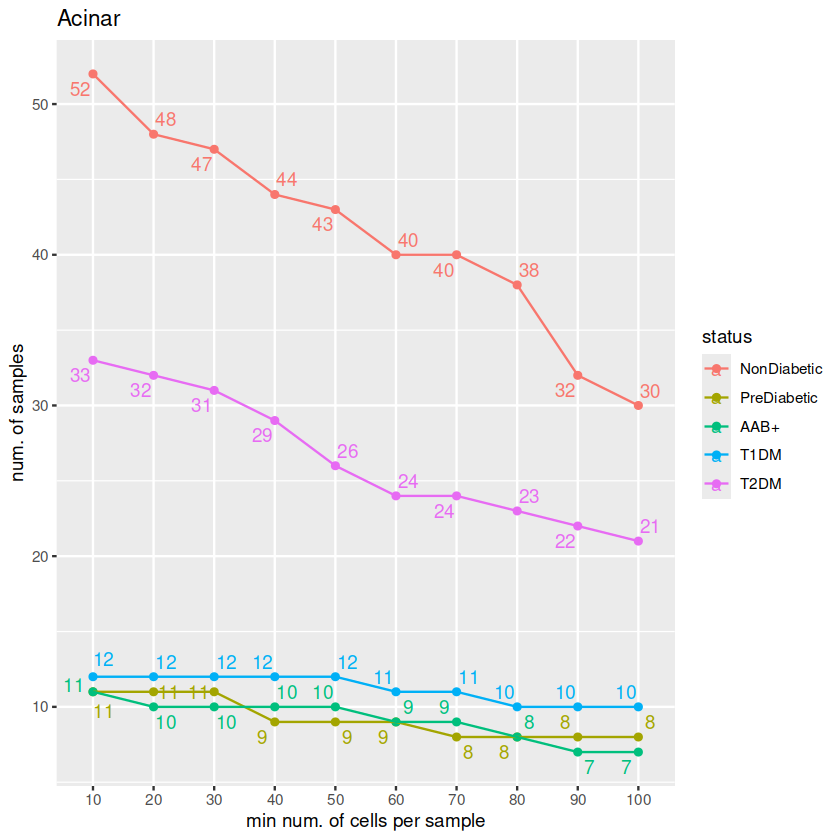

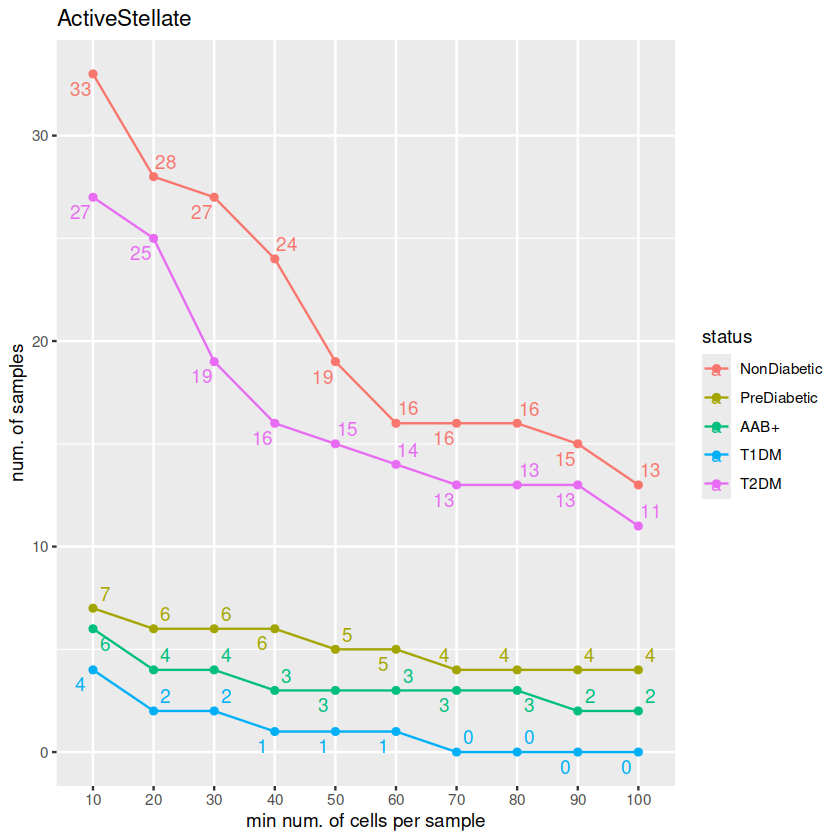

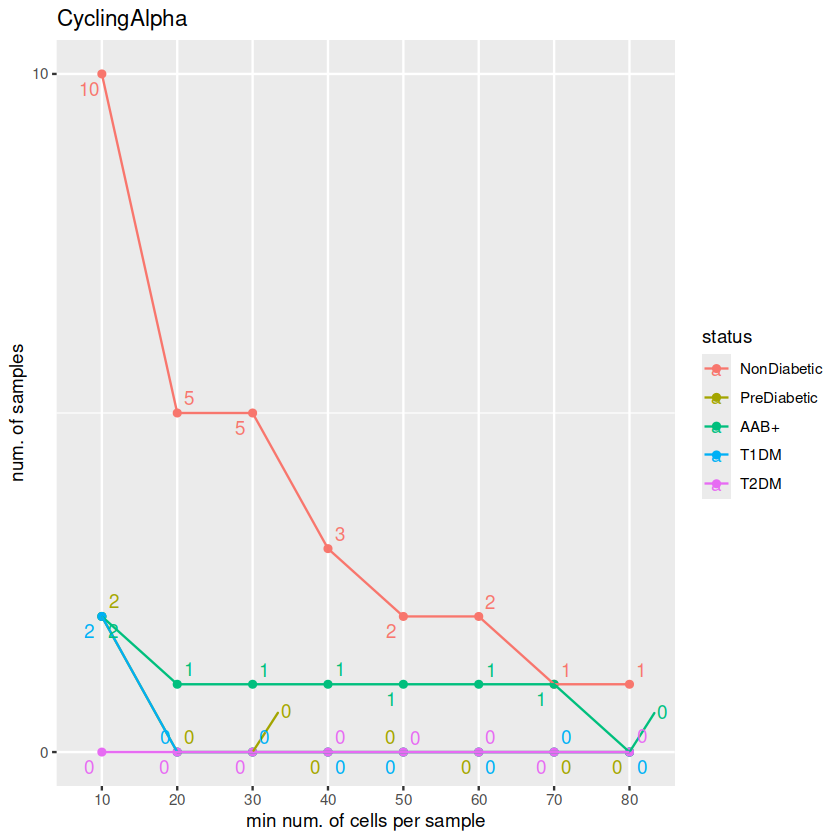

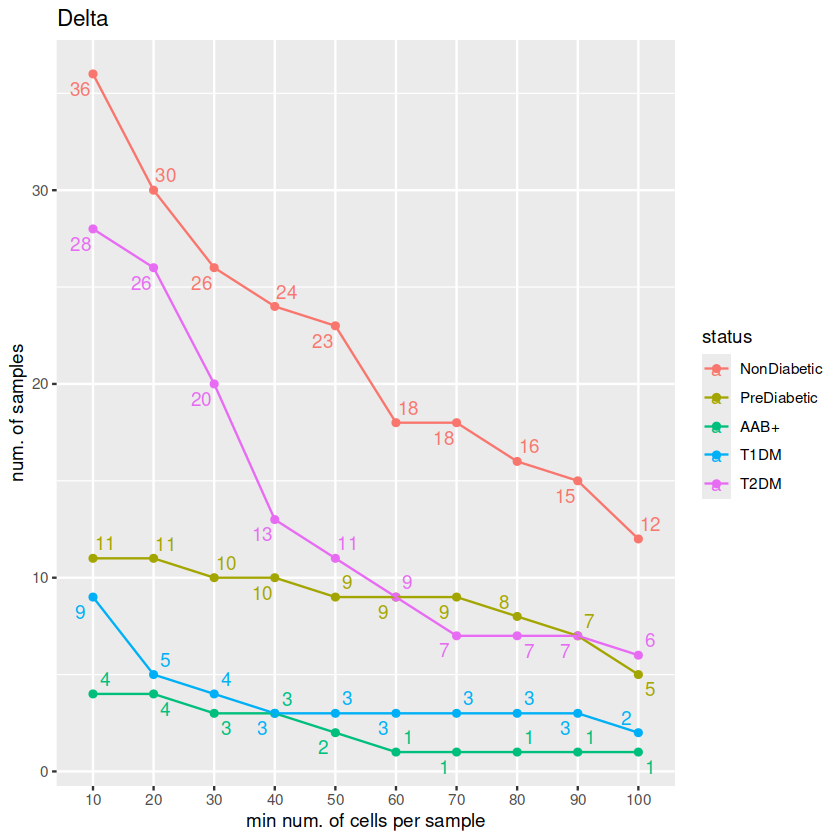

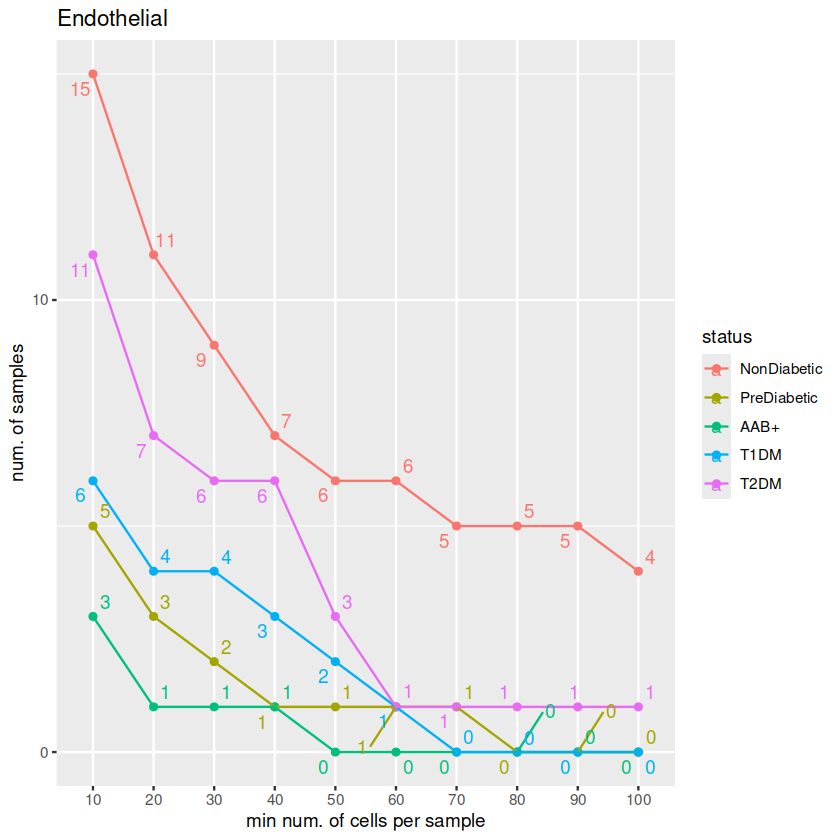

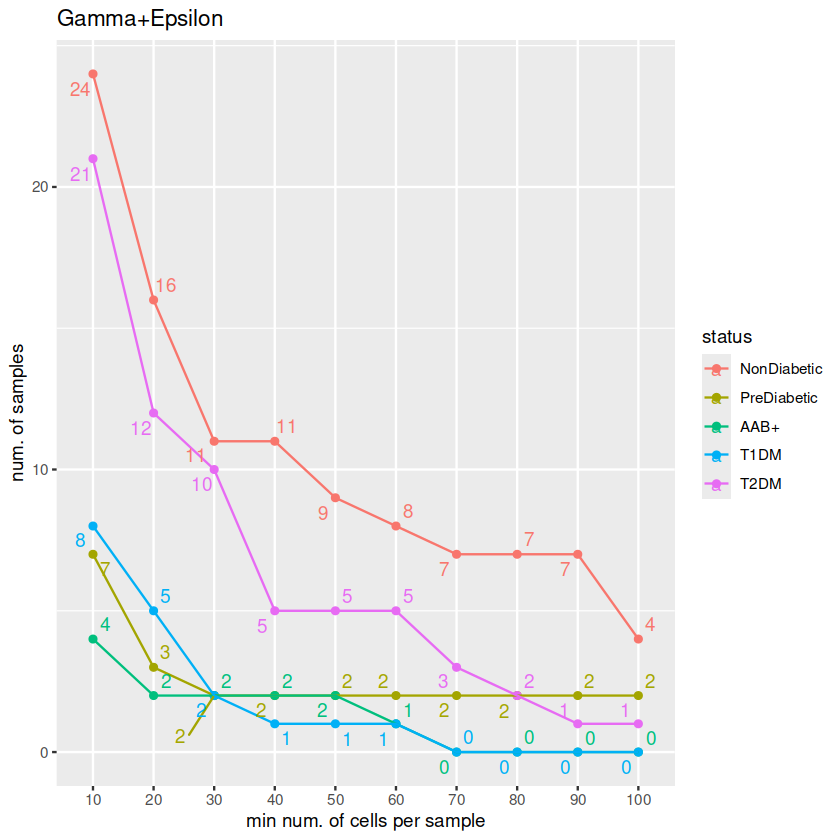

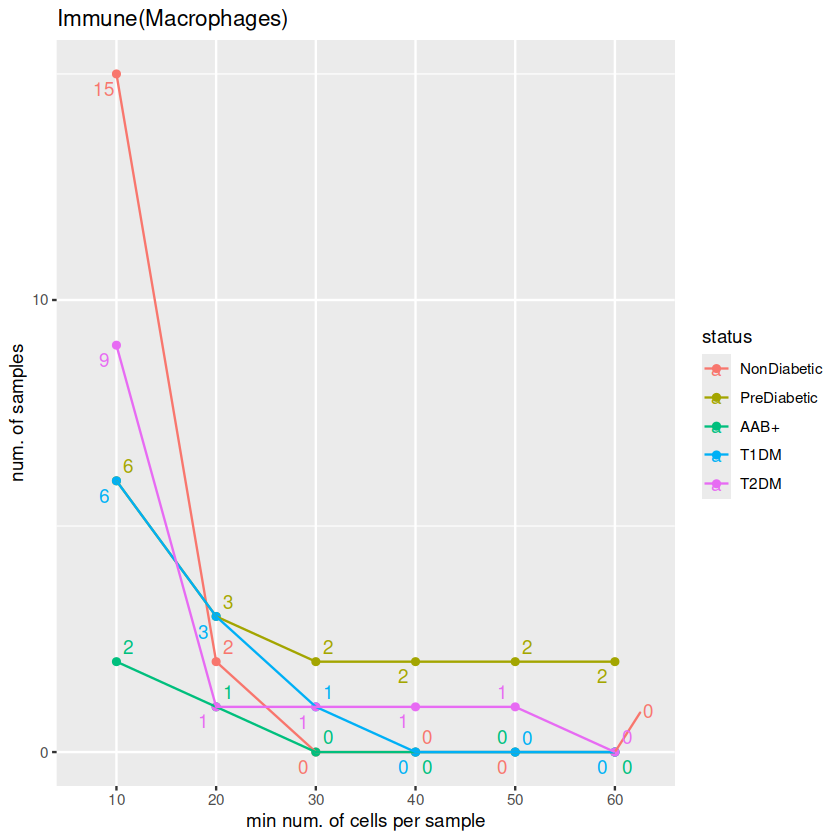

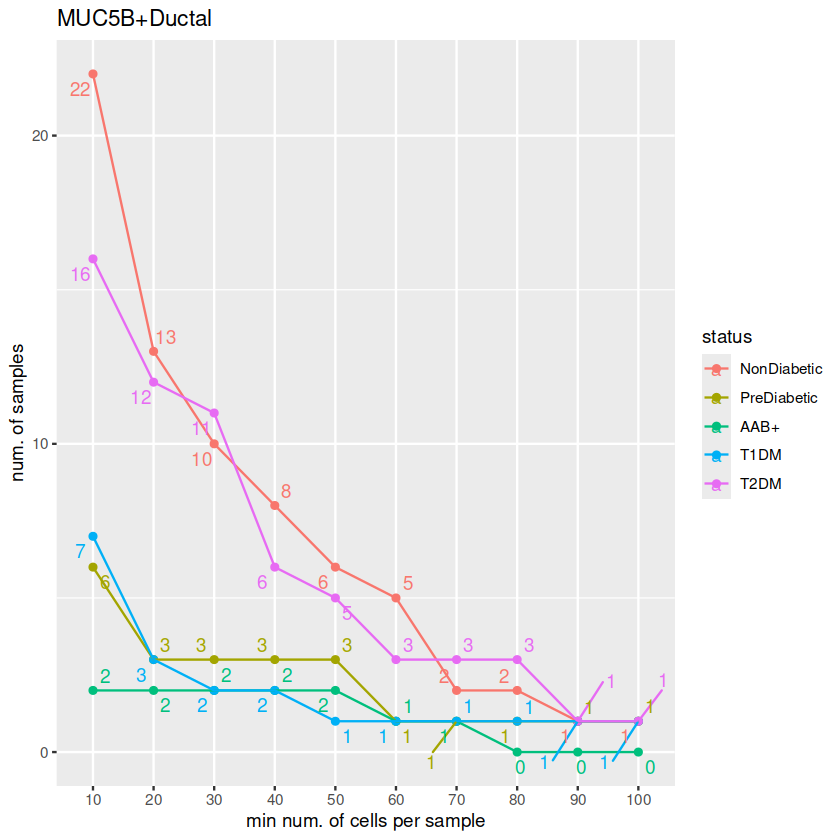

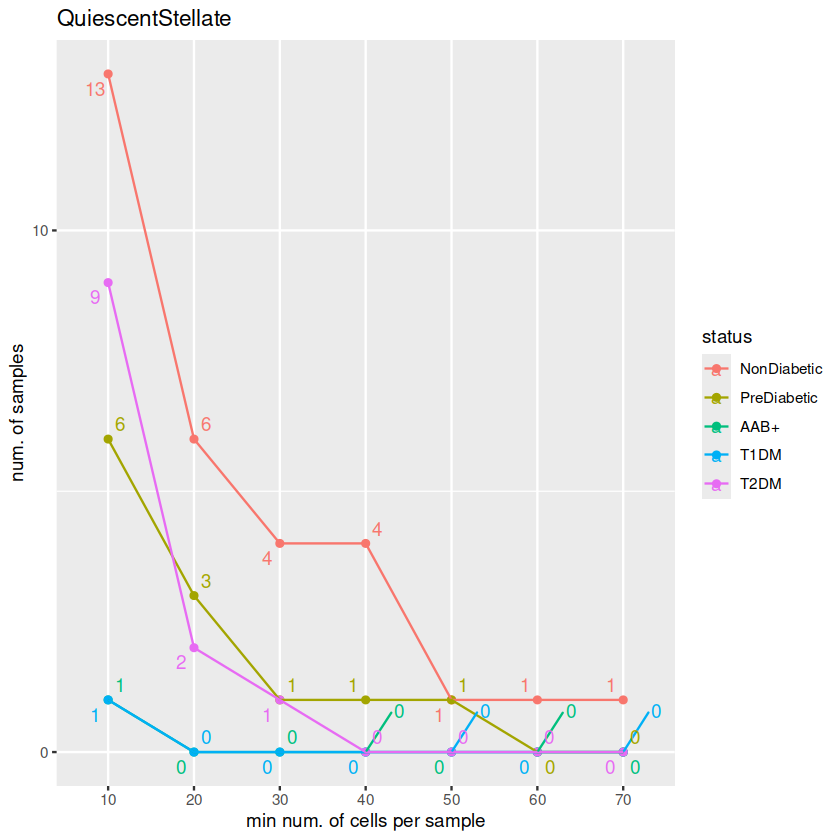

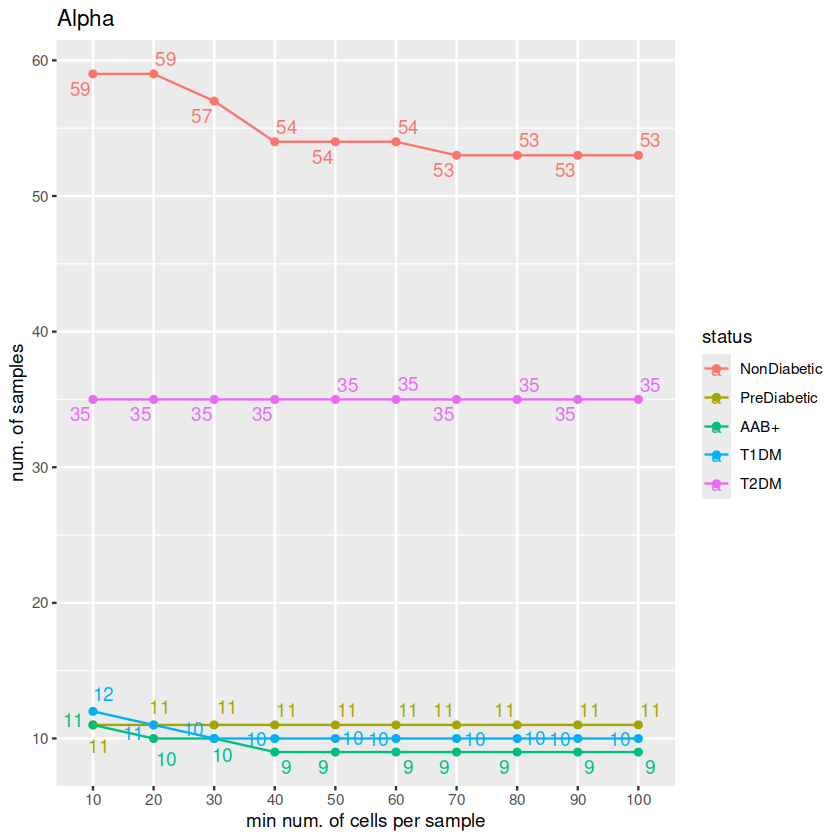

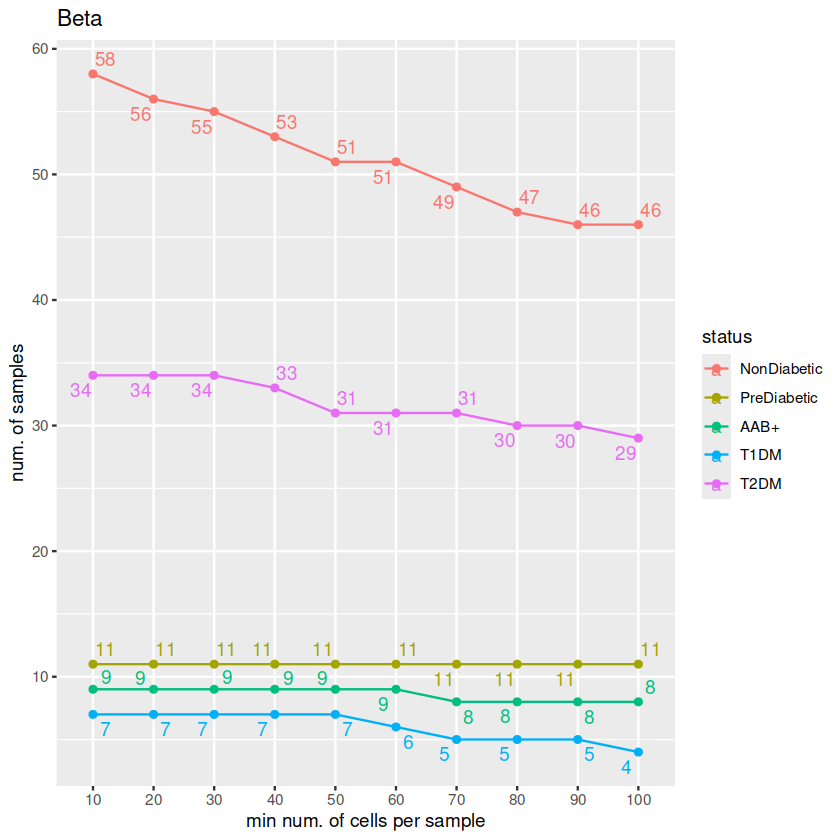

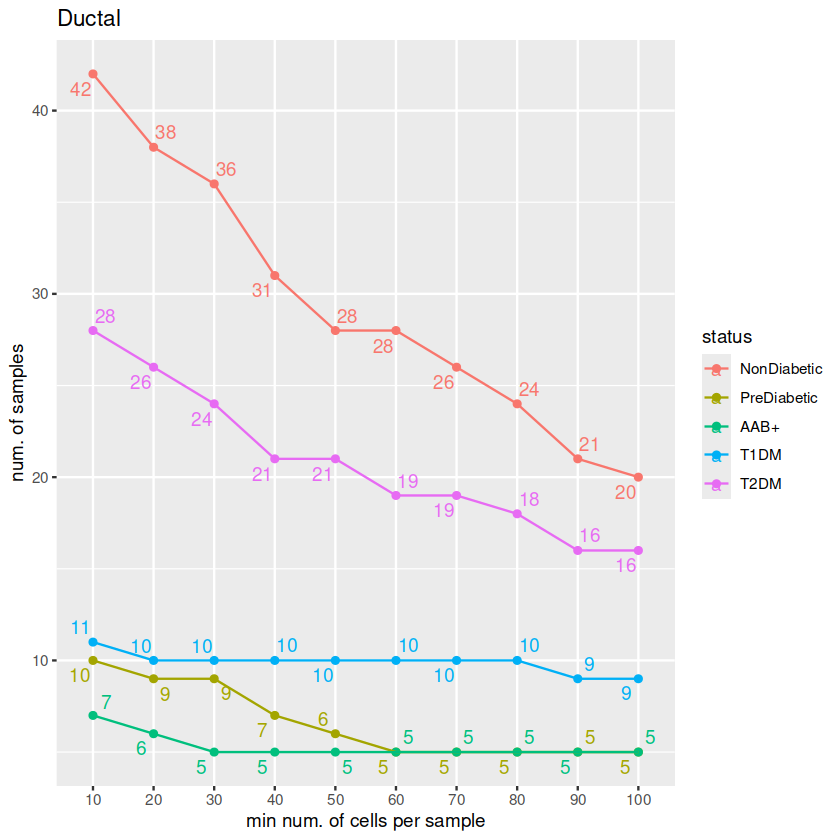

In [4]:
for (c in c("Acinar", "ActiveStellate", "CyclingAlpha", "Delta", "Endothelial", 
            "Gamma+Epsilon", "Immune(Macrophages)", "MUC5B+Ductal", "QuiescentStellate", 
            "Alpha", "Beta", "Ductal")) {
    cell.prop <- read.table(paste0("/nfs/turbo/umms-scjp-pank/5_DEG/results/cell_proportion/cell.prop_", c, ".txt"), header = T) # cell counts and propositions in large map
    metadata <- meta_in_sc
    metadata <- metadata[metadata$treatments == "no_treatment",]

    a <- data.frame(table(metadata$rrid))
    coldata <- metadata[metadata$rrid %in% a[a$Freq == 1, "Var1"],]
    for (i in a[a$Freq > 1, "Var1"]) {
        tmp <- metadata[metadata$rrid == i,]

        set.seed(1234)
        tmp <- tmp[sample(1:nrow(tmp), 1),]
        coldata <- rbind(coldata, tmp) #coldata has unique sample per donor; no donor has multiple samples
    }
    cell.prop <- inner_join(cell.prop, metadata, by = c("Var1" = "samples"))
    cell.prop$aab <- "0"
    cell.prop$aab <- ifelse(cell.prop$aab_gada == "TRUE", "AAB+", cell.prop$aab)
    cell.prop$aab <- ifelse(cell.prop$aab_ia_2 == "TRUE", "AAB+", cell.prop$aab)
    cell.prop$aab <- ifelse(cell.prop$aab_iaa == "TRUE", "AAB+", cell.prop$aab)
    cell.prop$aab <- ifelse(cell.prop$aab_znt8 == "TRUE", "AAB+", cell.prop$aab)
    cell.prop$diabetes_status_description <- ifelse(cell.prop$aab == "0" & cell.prop$diabetes_status_description != "T1DM", 
                                                    cell.prop$diabetes_status_description,
                                                   ifelse(cell.prop$aab == "AAB+" & cell.prop$diabetes_status_description == "NonDiabetic",
                                                         cell.prop$aab, cell.prop$diabetes_status_description))
    for (thres in 10) {
        tmp <- cell.prop[cell.prop$Freq > thres,]
        tmp$diabetes_status_description <- factor(tmp$diabetes_status_description, levels = c("NonDiabetic", "PreDiabetic", "AAB+", "T1DM", "T2DM"))
        df <- data.frame(table(tmp[tmp$Var1 %in% intersect(coldata$samples, tmp$Var1), "diabetes_status_description"]))
        df$thres <- thres
    }

    for (thres in seq(20, 100, 10)) {
        tmp <- cell.prop[cell.prop$Freq > thres,]
        if (nrow(tmp) > 0) {
            tmp$diabetes_status_description <- factor(tmp$diabetes_status_description, levels = c("NonDiabetic", "PreDiabetic", "AAB+", "T1DM", "T2DM"))
            df_tmp <- data.frame(table(tmp[tmp$Var1 %in% intersect(coldata$samples, tmp$Var1), "diabetes_status_description"]))
            df_tmp$thres <- thres
            df <- rbind(df, df_tmp)
        } else {
            df_tmp <- data.frame(Var1 = c("NonDiabetic", "PreDiabetic", "AAB+", "T1DM", "T2DM"), Freq = c(0, 0, 0, 0, 0), thres = c(thres, thres, thres, thres, thres))
        }
    }
    colnames(df) <- c("status", "n_donors", "thres")

    p <- ggplot(df, aes(x = factor(thres), y = n_donors, group = status, color = status)) + 
        geom_point() + geom_line() + xlab("min num. of cells per sample") + ylab("num. of samples") +
        ggrepel::geom_text_repel(aes(label = n_donors)) + 
        scale_y_continuous(breaks = seq(0, 80, 10)) + ggtitle(c)
    print(p)
}

Choose to include samples with > 20 cells per cell type to include in downstream DEG analysis. We'll focus on the cell types that have total number of samples across both phenotypes > 20 for the DEG analysis.